# Preprocessing

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LogisticRegression

We import and preapare the data for use.

In [39]:
df = pd.read_csv('../data/telecom_sales_data.csv')

In [40]:
# rename first column to 'date'
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# for ease of use
jphone = 'jPhone_Pro_revenue'
kaggle = 'Kaggle_Pixel_5_revenue'
planet = 'Planet_SX_revenue'

# remove nan errors
df['tech_event'] = df['tech_event'].fillna('')


For the time being, we will use Paris as the city of interest.

In [41]:
df_paris = df[df['city'] == 'Paris'].drop(columns=['city'])
df_paris.dropna(inplace=True)

# Modeling

As the requiered model is a prediction over time, we will naturally search for a time series model that fits our data. This is due to the apparent seasonality of the data.

For now, we will focus on jPhone

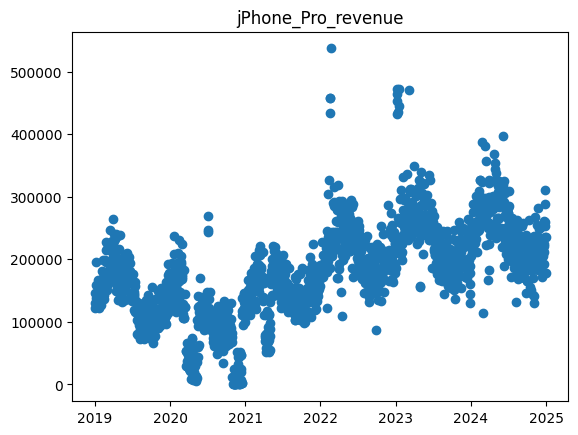

In [42]:
plt.scatter(df_paris.index, df_paris[jphone], label='jPhone_Pro_revenue')
plt.title('jPhone_Pro_revenue')
plt.show()

Given the prevous analysis of the data, there were some trends with repect to month and day of the week, so we will include these in the data. Also, we will add the quarter of the year.

In [43]:
df_paris['day_of_week'] = df_paris.index.dayofweek
df_paris['month'] = df_paris.index.month
df_paris['quarter'] = df_paris.index.quarter
df_paris['year'] = df_paris.index.year
df_paris['day_of_year'] = df_paris.index.dayofyear

df_paris['date'] = df_paris.index
df_paris['ordinal'] = df_paris['date'].apply(lambda x: x.toordinal())
df_paris.drop(columns=['date'], inplace=True)

time_columns = ['month', 'quarter', 'day_of_week', 'day_of_year','year','ordinal']

In [44]:

dict_cath = {'Bad': 0, 'Good': 1, 'Moderate': 2,
             '': 0, 'Tech Show': 1, 'Major Launch': 2,
             'Pre-5G': 0, 'Early-5G': 1, 'Mid-5G': 2, 'Mature-5G': 3,
             'Poor': 0, 'Limited': 1, 'Good': 2, 'Hub': 3}

df_paris = df_paris.replace(dict_cath)

We note that there is some recurring pattern in the data, so a time serios model should be able to capture this. Given that the model is expected to predict 3 monts on the basis of 60, we will use three monts of data for testing, as the proportion is similar in the training data: 3/57 = 0,0526.

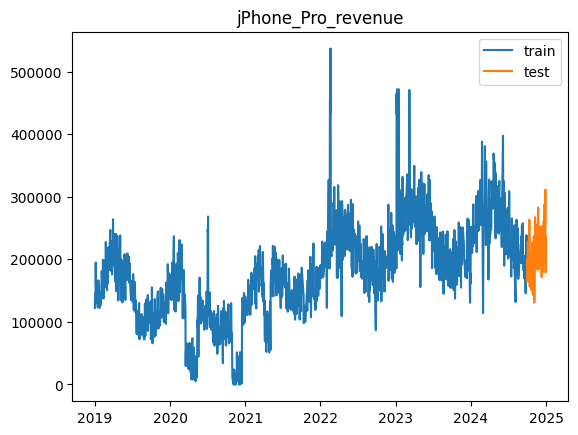

In [45]:
X_train = df_paris[df_paris.index < '2024-10-01'].drop(columns=[jphone, kaggle, planet])
X_test = df_paris[df_paris.index >= '2024-10-01'].drop(columns=[jphone, kaggle, planet])
y_train = df_paris[jphone][df_paris.index < '2024-10-01']
y_test = df_paris[jphone][df_paris.index >= '2024-10-01']

plt.plot(y_train.index, y_train, label='train')
plt.plot(y_test.index, y_test, label='test')
plt.title('jPhone_Pro_revenue')
plt.legend()
plt.show()

In [46]:
def split_data():
    X_train = df_paris[df_paris.index < '2024-10-01'].drop(columns=[jphone, kaggle, planet])
    X_test = df_paris[df_paris.index >= '2024-10-01'].drop(columns=[jphone, kaggle, planet])
    y_train = df_paris[jphone][df_paris.index < '2024-10-01']
    y_test = df_paris[jphone][df_paris.index >= '2024-10-01']

    return X_train, X_test, y_train, y_test

## Modeling

Now we use xGBoost regression

In [47]:
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.02)
reg.fit(X_train, y_train, 
        eval_set = [(X_train,y_train), (X_test,y_test)],
        verbose=100)

[0]	validation_0-rmse:72359.65581	validation_1-rmse:47682.44576
[100]	validation_0-rmse:24489.38099	validation_1-rmse:33879.23198
[200]	validation_0-rmse:17517.18759	validation_1-rmse:32512.67400
[236]	validation_0-rmse:16194.07201	validation_1-rmse:32747.22938


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

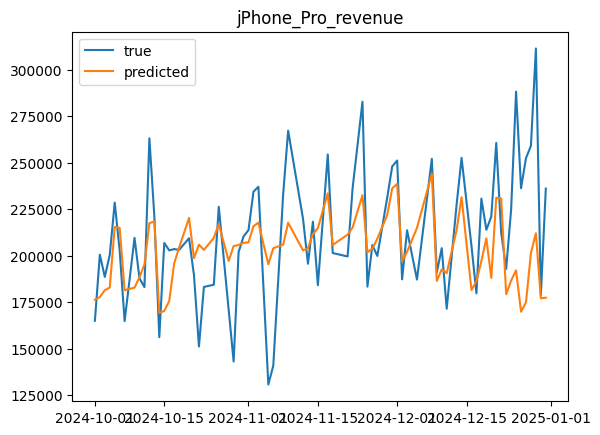

In [48]:
plt.plot(y_test.index, y_test, label='true')
plt.plot(y_test.index, reg.predict(X_test), label='predicted')
plt.title('jPhone_Pro_revenue')
plt.legend()
plt.show()

We will not, _a priori_ have columns like weather conditions for the future. Hence, we will try to predict these values using a time series model.

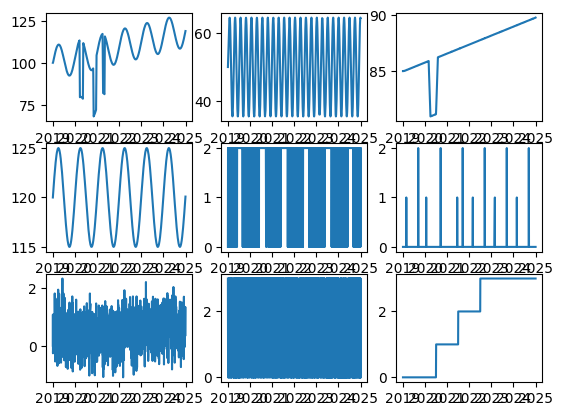

Index(['marketing_score', 'competition_index', 'customer_satisfaction',
       'purchasing_power_index', 'weather_condition', 'tech_event', '5g_phase',
       'store_traffic', 'public_transport', 'jPhone_Pro_revenue',
       'Kaggle_Pixel_5_revenue', 'Planet_SX_revenue', 'day_of_week', 'month',
       'quarter', 'year', 'day_of_year', 'ordinal'],
      dtype='object')

In [49]:
fig, ax = plt.subplots(3,3)

ax[0,0].plot(df_paris.index, df_paris['marketing_score'], label='marketing_score')
ax[0,1].plot(df_paris.index, df_paris['competition_index'], label='competition_index')
ax[0,2].plot(df_paris.index, df_paris['customer_satisfaction'], label='customer_satisfaction')
ax[1,0].plot(df_paris.index, df_paris['purchasing_power_index'], label='purchasing_power_index')
ax[1,1].plot(df_paris.index, df_paris['weather_condition'], label='weather_condition')
ax[1,2].plot(df_paris.index, df_paris['tech_event'], label='tech_event')
ax[2,0].plot(df_paris.index, df_paris['store_traffic'], label='store_traffic')
ax[2,1].plot(df_paris.index, df_paris['public_transport'], label='public_transport')
ax[2,2].plot(df_paris.index, df_paris['5g_phase'], label='5g_phase')


plt.show()
df_paris.columns

We observe that a bunch of the variables seem fairly predictable, so we will tray to predict them with time series.

In [50]:
def ts_predict(col_name, cols = time_columns):
    X_tr, X_ts = X_train[cols], X_test[cols]
    y_tr, y_ts = X_train[col_name], X_test[col_name]

    reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.02)
    reg.fit(X_tr, y_tr, 
            eval_set = [(X_tr,y_tr), (X_ts,y_ts)],
            verbose=0)
    
    return reg.predict(X_ts), reg.feature_importances_

In [51]:
time_columns

['month', 'quarter', 'day_of_week', 'day_of_year', 'year', 'ordinal']

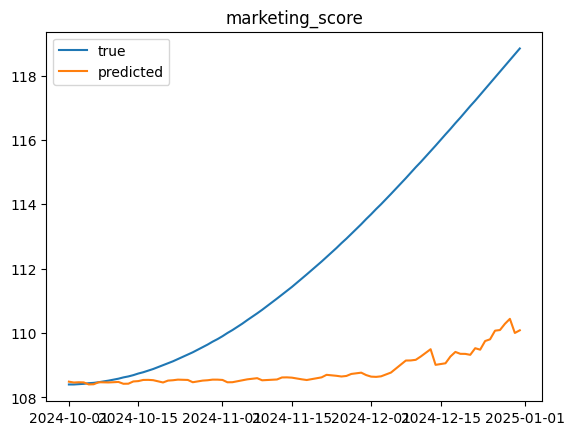

array([2.2230694e-01, 0.0000000e+00, 2.9881528e-04, 9.6617274e-02,
       2.9702958e-01, 3.8374731e-01], dtype=float32)

In [52]:
marketing_pred, importances = ts_predict('marketing_score')

col_name = 'marketing_score'

plt.plot(X_test.index, X_test[col_name], label='true')
plt.plot(X_test.index, marketing_pred, label='predicted')
plt.title(col_name)
plt.legend()
plt.show()
importances

We make a little exploration (without worrying about the train-test split) to use linear regression to make the data stationary

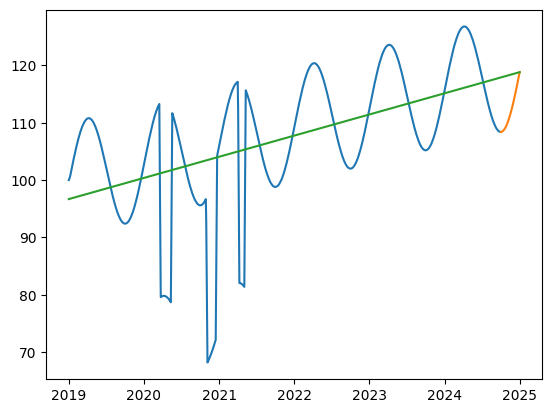

In [53]:
# linear regression
x = X_train['ordinal']
y = X_train['marketing_score']
x_with_int = add_constant(x)
model = OLS(y,x_with_int).fit()
x_total = add_constant(df_paris['ordinal'])
y_pred_total = model.predict(x_total)

plt.plot(X_train.index, y, label='train')
plt.plot(X_test.index, X_test['marketing_score'], label='test')
plt.plot(df_paris.index, y_pred_total, label='predicted')

In [54]:
def pred_var(col_name,cols = time_columns):
    # linear regression
    x_reg = X_train['ordinal']
    y_train_reg = X_train[col_name]
    x_reg_with_int = add_constant(x_reg)
    model = OLS(y_train_reg,x_reg_with_int).fit()
    # normalise
    y_tr = X_train[col_name] - model.predict(x_reg_with_int)
    y_te = X_test[col_name] - model.predict(add_constant(X_test['ordinal']))
    X_tr, X_ts = X_train[cols], X_test[cols]
    reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.02)
    reg.fit(X_tr, y_tr, 
            eval_set = [(X_tr,y_tr), (X_ts,y_te)],
            verbose=0)
    return reg.predict(X_ts) + model.predict(add_constant(X_test['ordinal'])), reg.feature_importances_

In [55]:
def plot_pred_var(col_name,cols= time_columns):
    pred, importances = pred_var(col_name)
    plt.plot(X_test.index, X_test[col_name], label='true')
    plt.plot(X_test.index, pred, label='predicted')
    plt.title(col_name)
    plt.legend()
    plt.show()
    return importances

In [56]:
df_paris.columns

Index(['marketing_score', 'competition_index', 'customer_satisfaction',
       'purchasing_power_index', 'weather_condition', 'tech_event', '5g_phase',
       'store_traffic', 'public_transport', 'jPhone_Pro_revenue',
       'Kaggle_Pixel_5_revenue', 'Planet_SX_revenue', 'day_of_week', 'month',
       'quarter', 'year', 'day_of_year', 'ordinal'],
      dtype='object')

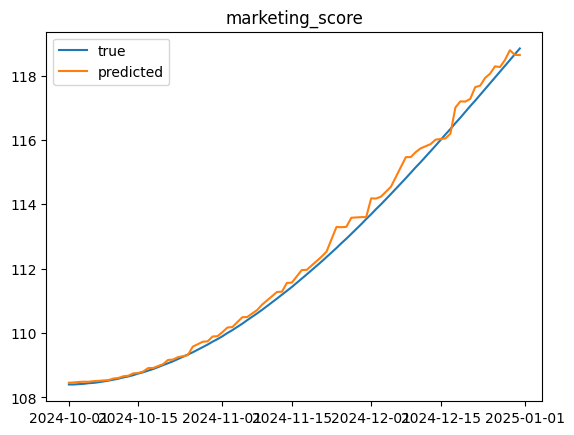

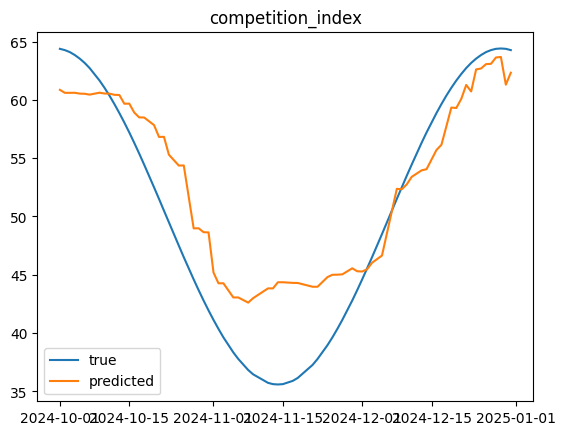

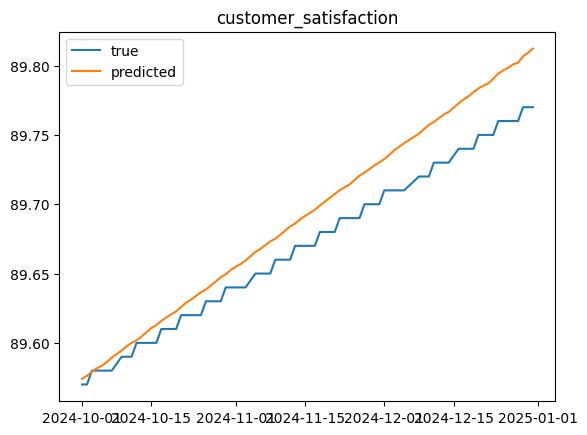

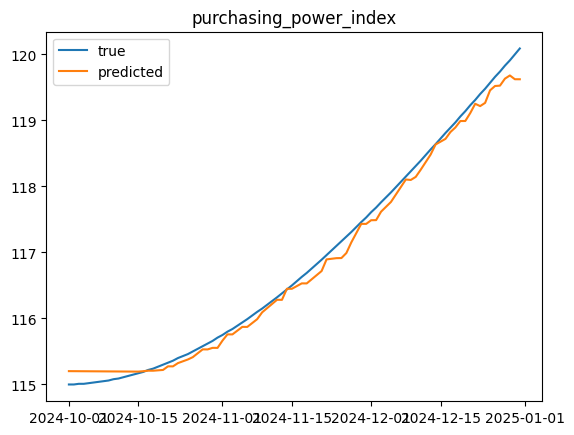

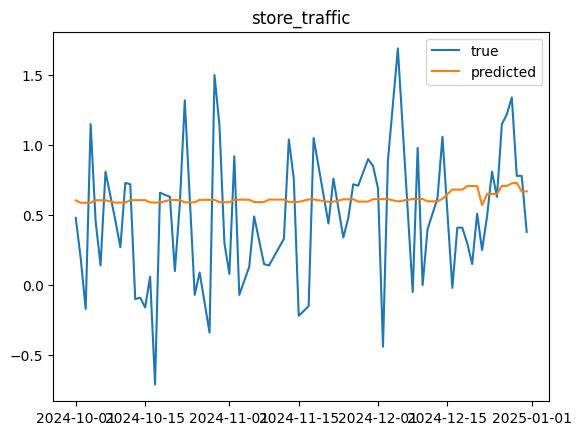

array([0.1543677 , 0.        , 0.17733066, 0.22782023, 0.14417084,
       0.29631054], dtype=float32)

In [57]:
# plots continous vairables
plot_pred_var('marketing_score')
plot_pred_var('competition_index')
plot_pred_var('customer_satisfaction')
plot_pred_var('purchasing_power_index')
plot_pred_var('store_traffic')

For the other variables, we study them:

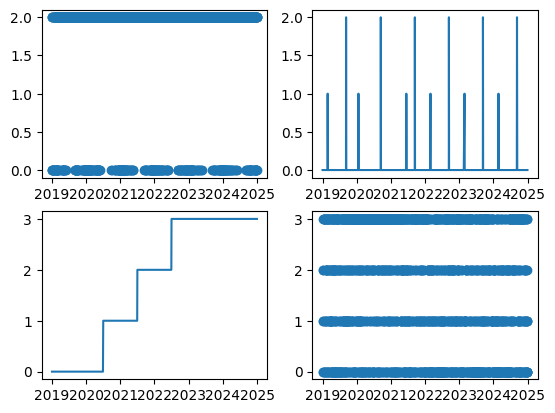

In [58]:
# subplots of df_paris for 'weather_condition', 'tech_event', '5g_phase', 'public_transport'

fig, ax = plt.subplots(2,2)

ax[0,0].scatter(df_paris.index, df_paris['weather_condition'], label='weather_condition')
ax[0,1].plot(df_paris.index, df_paris['tech_event'], label='tech_event')
ax[1,0].plot(df_paris.index, df_paris['5g_phase'], label='5g_phase')
ax[1,1].scatter(df_paris.index, df_paris['public_transport'], label='public_transport')

We notice that our approach might not be the best for 5g phase, so we define a new approach for this variable. THe behavior of the variable is clearly a staircase function, so will use logistic regression to predict the values of this variable.

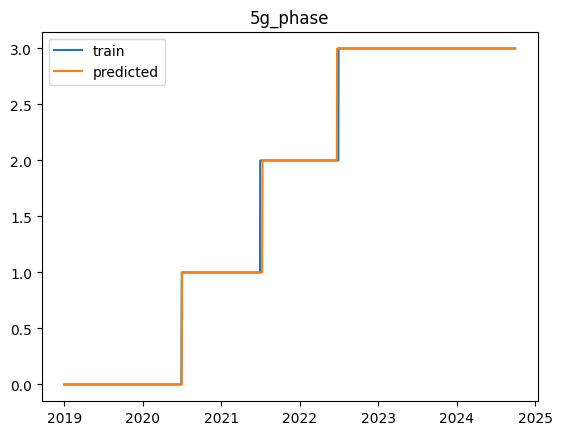

In [59]:
x = np.array(X_train['ordinal'])
x = x.reshape(-1, 1)
x = StandardScaler().fit_transform(x)
y = np.array(X_train['5g_phase'])
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
model.fit(x, y)
y_pred = model.predict(x)

plt.plot(X_train.index, y, label='train')
plt.plot(X_train.index, y_pred, label='predicted')
plt.title('5g_phase')
plt.legend()
plt.show()

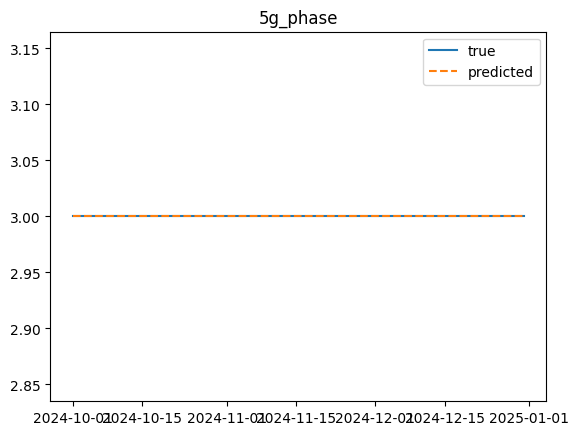

In [60]:
# now over the X_test
x_5g_test = np.array(X_test['ordinal']).reshape(-1, 1)
y_5g_pred_test = model.predict(x_5g_test)
y_5g_test = X_test['5g_phase']

plt.plot(X_test.index, y_5g_test, label='true')
plt.plot(X_test.index, y_5g_pred_test, label='predicted',linestyle='dashed')
plt.title('5g_phase')
plt.legend()
plt.show()

We found a suitable predictor. Now we construct a function.

In [61]:
def VG_pred(cols = time_columns):
    x = np.array(X_train['ordinal']).reshape(-1, 1)
    x = StandardScaler().fit_transform(x)
    y = np.array(X_train['5g_phase'])
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
    model.fit(x, y)
    y_pred = model.predict(x)
    x_test = np.array(X_test['ordinal']).reshape(-1, 1)
    y_pred_test = model.predict(x_test)
    return y_pred_test

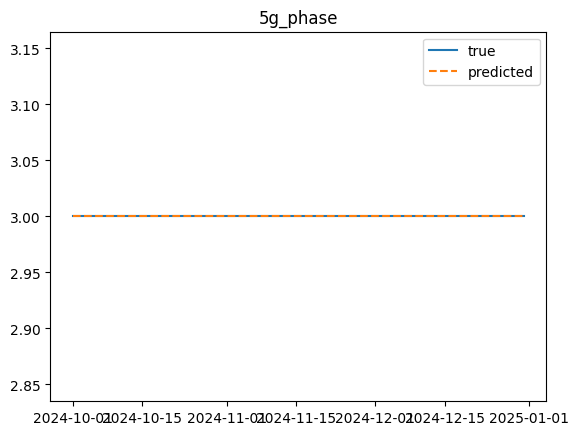

In [62]:
pred_vg = VG_pred()

plt.plot(X_test.index, X_test['5g_phase'], label='true')
plt.plot(X_test.index, pred_vg, label='predicted',linestyle='dashed')
plt.title('5g_phase')
plt.legend()
plt.show()

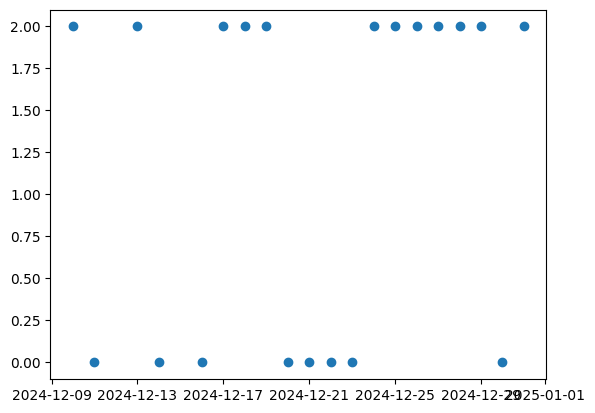

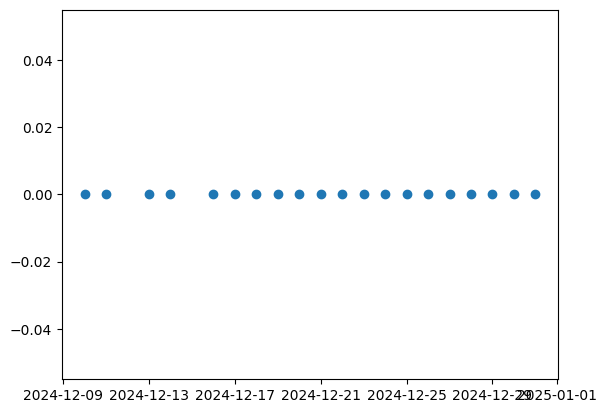

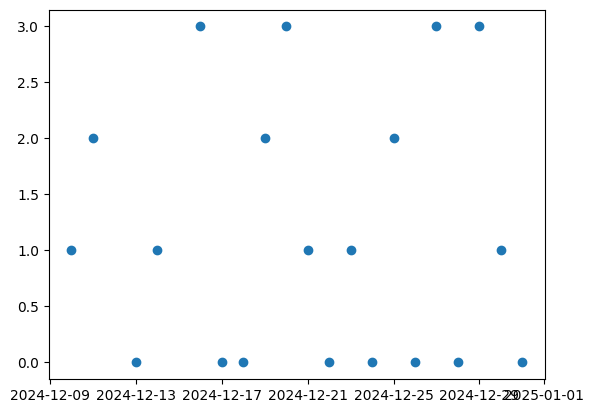

In [63]:
n = 20
plt.scatter(df_paris.tail(n).index, df_paris.tail(n)['weather_condition'], label='weather_condition')
plt.show()
plt.scatter(df_paris.tail(n).index, df_paris.tail(n)['tech_event'], label='tech_event')
plt.show()
plt.scatter(df_paris.tail(n).index, df_paris.tail(n)['public_transport'], label='public_transport')
plt.show()

It seems we have to surrender to a time series model for the other variables.

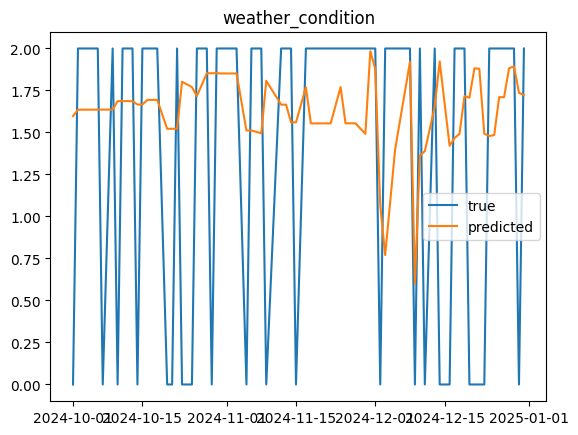

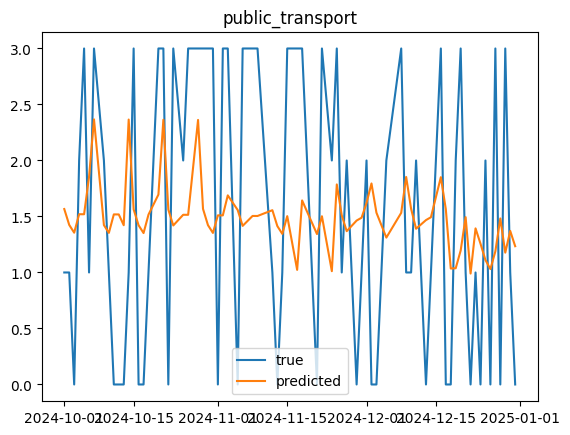

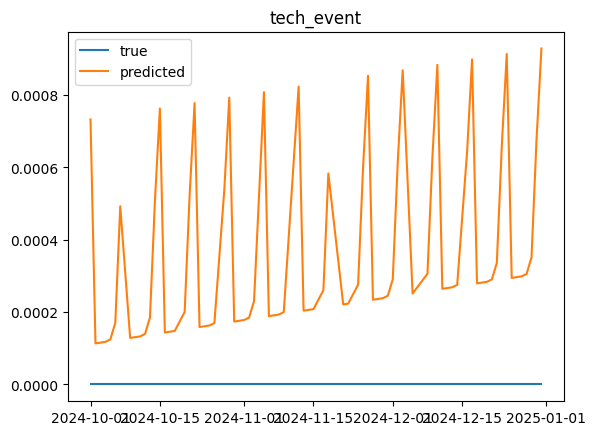

array([0.05846636, 0.        , 0.45929682, 0.3867142 , 0.04453575,
       0.05098689], dtype=float32)

In [64]:
# predict weather condition
plot_pred_var('weather_condition')
plot_pred_var('public_transport')
plot_pred_var('tech_event')

Now, we may predict once again, but now with predicted variables.

In [65]:
df_paris.columns

Index(['marketing_score', 'competition_index', 'customer_satisfaction',
       'purchasing_power_index', 'weather_condition', 'tech_event', '5g_phase',
       'store_traffic', 'public_transport', 'jPhone_Pro_revenue',
       'Kaggle_Pixel_5_revenue', 'Planet_SX_revenue', 'day_of_week', 'month',
       'quarter', 'year', 'day_of_year', 'ordinal'],
      dtype='object')

In [66]:
ts_columns = ['marketing_score', 'competition_index', 'customer_satisfaction',
       'purchasing_power_index', 'weather_condition', 'tech_event',
       'store_traffic', 'public_transport']
lr_columns = ['5g_phase']

true_cols = ['marketing_score', 'competition_index', 'customer_satisfaction',
       'purchasing_power_index', 'weather_condition', 'tech_event', '5g_phase',
       'store_traffic', 'public_transport', 'day_of_week', 'month',
       'quarter', 'year', 'day_of_year', 'ordinal']

pred_cols = ts_columns + lr_columns + time_columns

X_test_pred = pd.DataFrame(columns=true_cols, index=X_test.index)

for col in ts_columns:
    pred_vals = pred_var(col)
    nom_col = col
    X_test_pred[nom_col] = pred_vals[0]

X_test_pred['5g_phase'] = VG_pred()
X_test_pred[time_columns] = X_test[time_columns]

In [67]:
X_test_pred

,marketing_score,competition_index,customer_satisfaction,purchasing_power_index,weather_condition,tech_event,5g_phase,store_traffic,public_transport,day_of_week,month,quarter,year,day_of_year,ordinal
date,,,,,,,,,,,,,,,
2024-10-01,108.454106,60.861435,89.574133,115.202040,1.597237,0.000733,3,0.604821,1.566485,1,10,4,2024,275,739160
2024-10-02,108.464060,60.605863,89.576203,115.201529,1.635618,0.000114,3,0.587844,1.424741,2,10,4,2024,276,739161
2024-10-03,108.477537,60.605941,89.579235,115.201018,1.635696,0.000116,3,0.587989,1.355205,3,10,4,2024,277,739162
2024-10-04,108.485644,60.610635,89.581699,115.200507,1.635773,0.000118,3,0.588134,1.520135,4,10,4,2024,278,739163
2024-10-05,108.484576,60.539459,89.583576,115.199996,1.635851,0.000125,3,0.605670,1.519896,5,10,4,2024,279,739164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,118.263248,63.094297,89.800876,119.526978,1.710210,0.000299,3,0.708575,1.188502,4,12,4,2024,362,739247
2024-12-28,118.481619,63.637230,89.802035,119.632900,1.882167,0.000306,3,0.726565,1.482362,5,12,4,2024,363,739248
2024-12-29,118.786386,63.681466,89.806631,119.681219,1.894036,0.000351,3,0.729994,1.176885,6,12,4,2024,364,739249


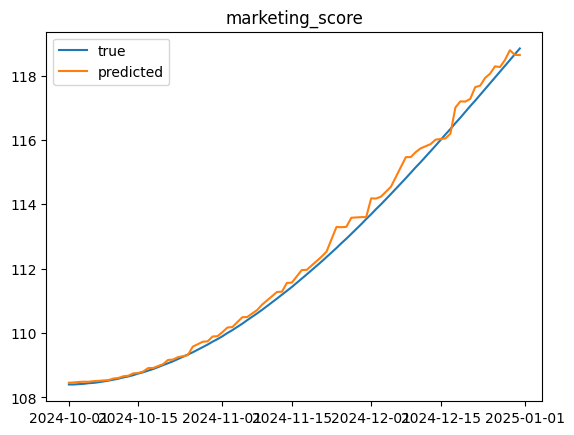

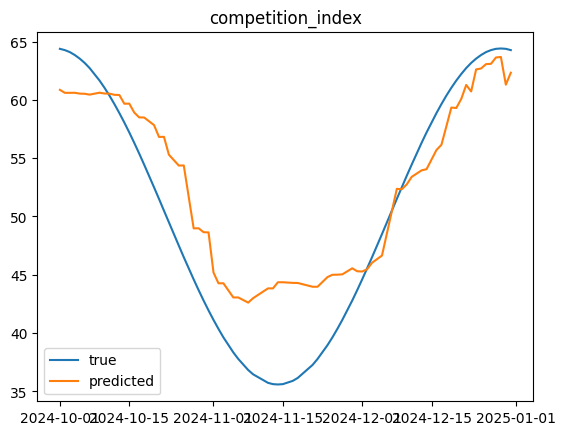

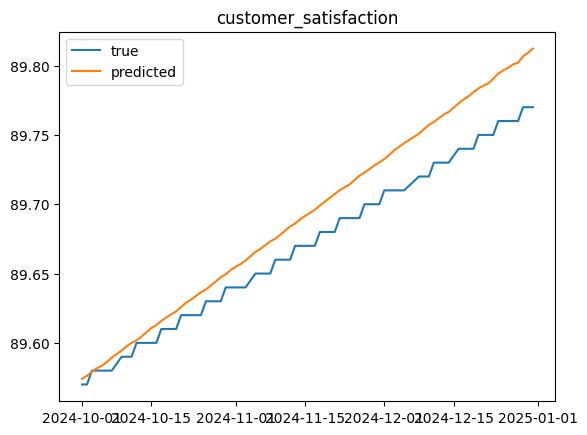

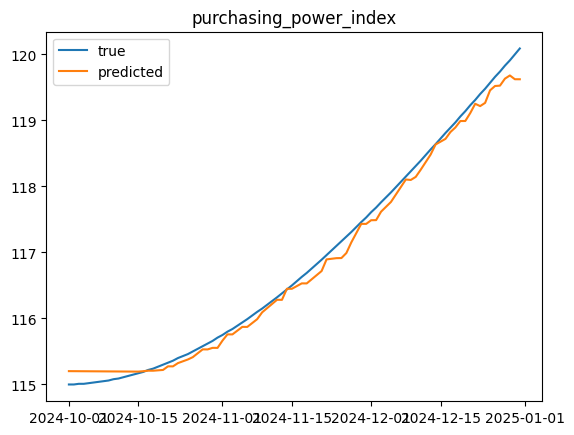

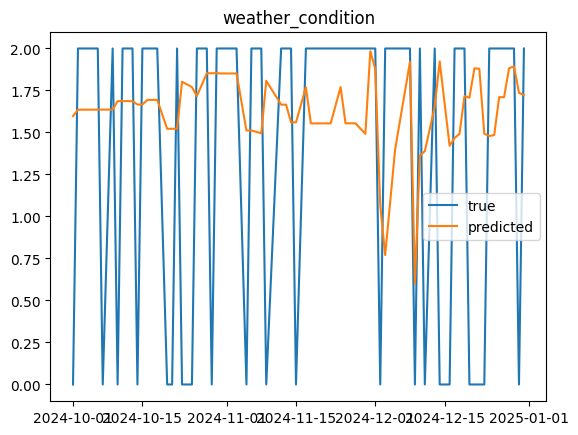

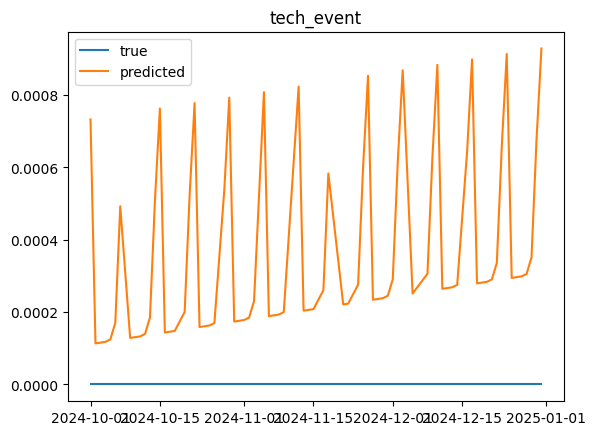

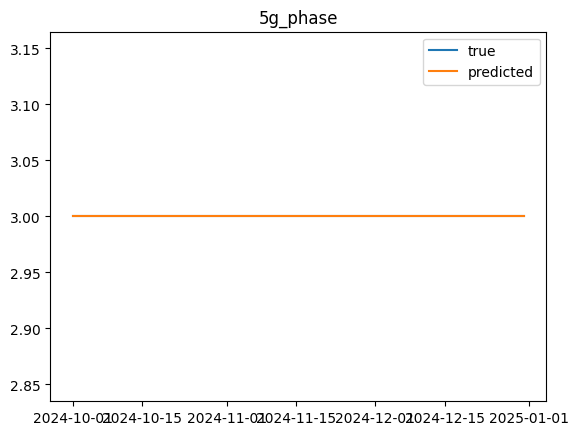

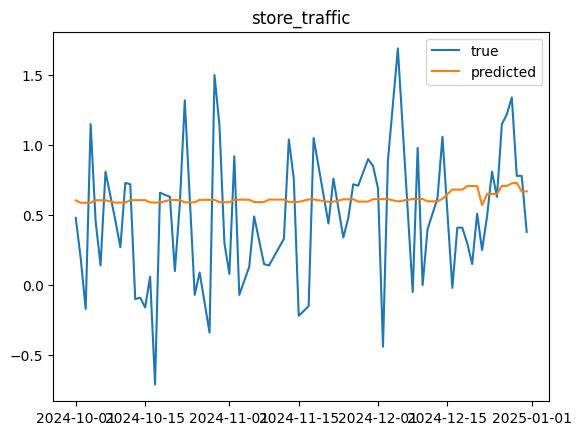

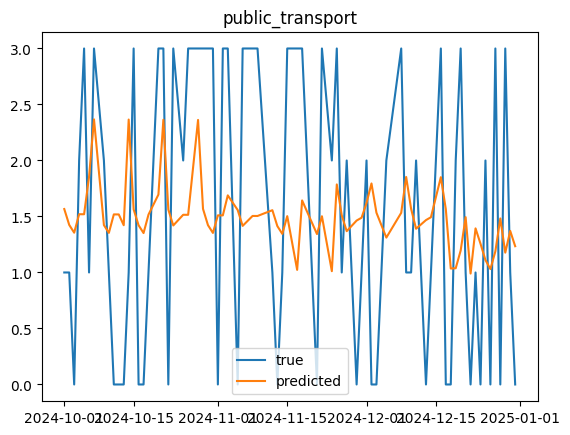

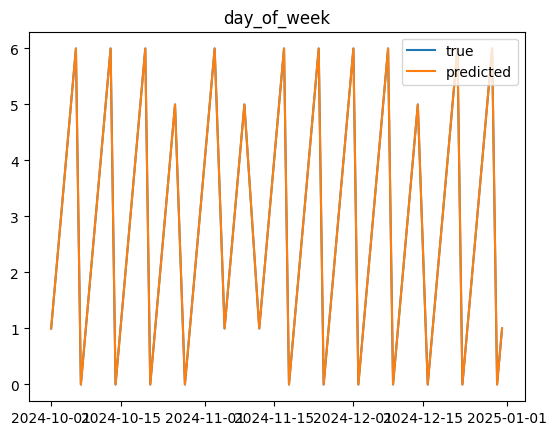

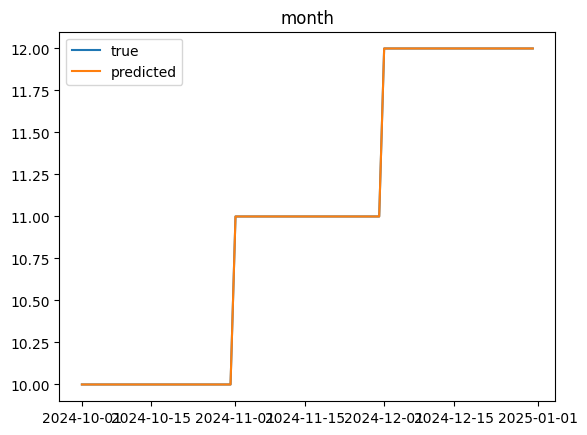

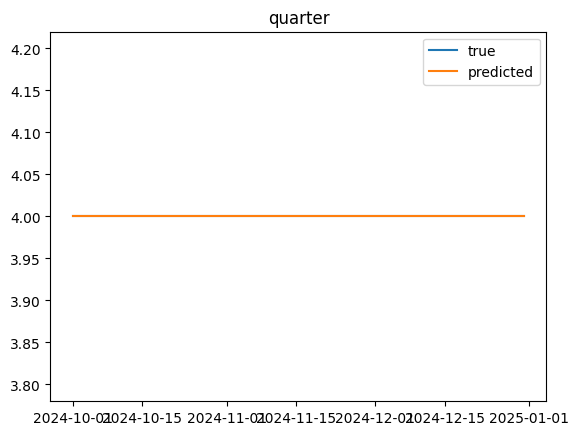

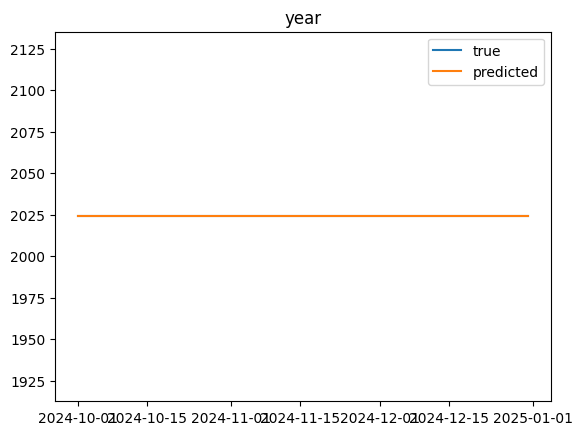

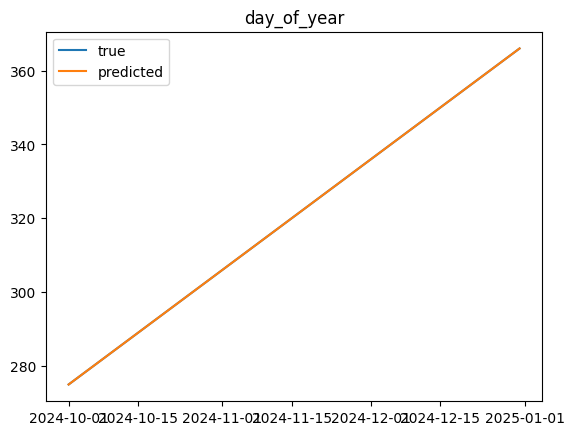

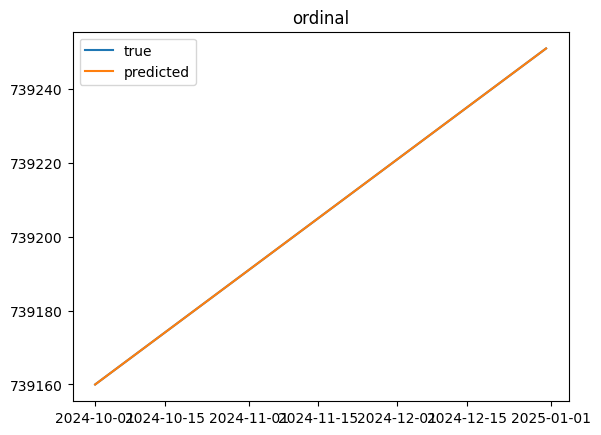

In [68]:
for col in true_cols:
    plt.plot(X_test.index, X_test[col], label='true')
    plt.plot(X_test.index, X_test_pred[col], label='predicted')
    plt.title(col)
    plt.legend()
    plt.show()

<Axes: xlabel='date'>

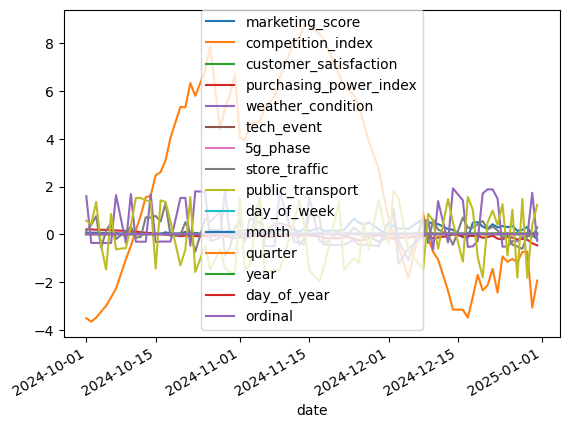

In [69]:
(X_test_pred - X_test).plot()

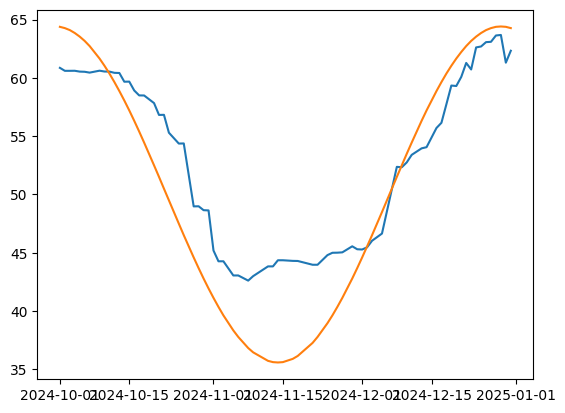

In [70]:
plt.plot(X_test.index, X_test_pred['competition_index'], label='predicted')
plt.plot(X_test.index, X_test['competition_index'], label='true')


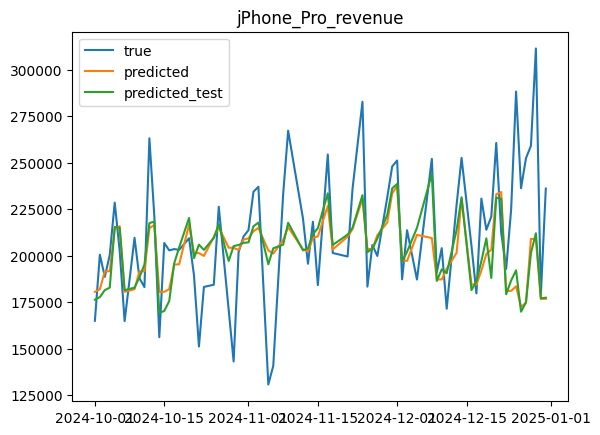

In [71]:
# plot with X_test_pred
plt.plot(X_test.index, y_test, label='true')
plt.plot(X_test.index, reg.predict(X_test_pred), label='predicted')
# plot with X_test
plt.plot(X_test.index, reg.predict(X_test), label='predicted_test')
plt.title('jPhone_Pro_revenue')
plt.legend()
plt.show()

We observe that our predictions are really good, such that the time series with predicted variables and the true variables are pretty much the same.

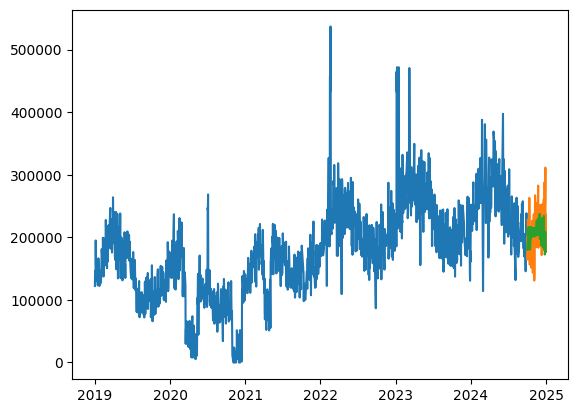

In [72]:
plt.plot(X_train.index, y_train, label='train')
plt.plot(X_test.index, y_test, label='test')
plt.plot(X_test.index, reg.predict(X_test_pred), label='predicted')

Now, we may incorporate our linear regression technique from earlier to make the data stationary.

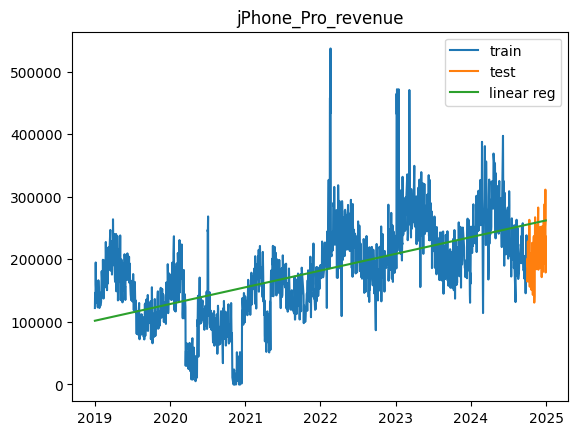

In [73]:
# linear regression
x = X_train['ordinal']
y = y_train
x_with_int = add_constant(x)
model = OLS(y,x_with_int).fit()
x_total = add_constant(df_paris['ordinal'])
y_pred_total = model.predict(x_total)

plt.plot(X_train.index, y_train, label='train')
plt.plot(X_test.index, y_test, label='test')
plt.plot(df_paris.index, y_pred_total, label='linear reg')
plt.title('jPhone_Pro_revenue')
plt.legend()
plt.show()

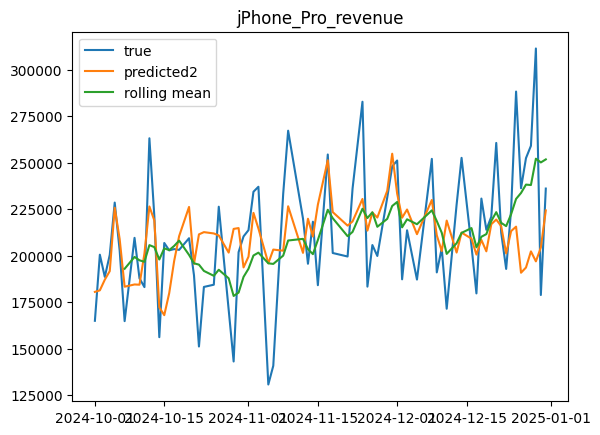

In [74]:
# me make the data stationary
y_tr = y_train - model.predict(x_with_int)
y_te = y_test - model.predict(add_constant(X_test['ordinal']))

reg2 = xgb.XGBRegressor(n_estimators=1000,learning_rate=0.02) #early_stopping_rounds=50
reg2.fit(X_train, y_tr, 
        #eval_set = [(X_train,y_tr), (X_test_pred,y_te)],
        verbose=0)

# add the linear regression prediction to the xgb prediction
#plt.plot(X_train.index, y_tr + model.predict(x_with_int), label='train')
plt.plot(y_test.index, y_test, label='true')
plt.plot(y_test.index, reg2.predict(X_test) + model.predict(add_constant(X_test['ordinal'])), label='predicted2')
#plt.plot(y_test.index, reg.predict(X_test_pred), label='predicted')
plt.title('jPhone_Pro_revenue')
# plot rolling mean
plt.plot(y_test.index, y_test.rolling(window=7).mean(), label='rolling mean')
plt.legend()
plt.show()

With this model exploration done, we may now proceed to the final model.